In [22]:
import pandas as pd

korean_air_data = pd.read_csv("korean_air_2020_01.csv")

korean_air_data.columns = ["a","title","text","editor","times","date"]


del korean_air_data["a"]

# na값 제거
data = korean_air_data.dropna()

date = data.date

# 불용어 지정
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','박정환','도','을','것','를','등','으로','자','에','등','와','한','하다''것','\n','로']

# 한글 외의 모든 데이터 제거 : 기업명이 영어로 되어있는 경우를 어떻게 처리 해야할까?
data = data.text.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer

okt = Okt()
X_train = []

for sen in data :
    temp_X = []
    
    # 토큰화
    temp_X = okt.morphs(sen, stem = True) 
    
    # 불용어 제거
    temp_X = [word for word in temp_X if not word in stopwords] 
    
    X_train.append(temp_X)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
vocab_size = total_cnt - rare_cnt
print('단어 집합의 크기 :',vocab_size)
    

단어 집합(vocabulary)의 크기 : 8648
등장 빈도가 2번 이하인 희귀 단어의 수: 4170
단어 집합에서 희귀 단어의 비율: 48.21924144310824
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.497673817523908
단어 집합의 크기 : 4478


In [2]:
nouns = []
str = ''

for k in range(0,len(X_train)):
    for i in range(0,len(X_train[k])):
        str = str + X_train[k][i] + ' '
    nouns.append(str)

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_df = pd.DataFrame()

tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfidf = tfIdfVectorizer.fit_transform(nouns)

for i in range(0,len(X_train)):
    df = pd.DataFrame(tfidf[i].T.toarray(), index=tfIdfVectorizer.get_feature_names(), columns=["text{}".format(i)])
    tfidf_df = pd.concat([tfidf_df,df],axis = 1)

In [4]:
X_train_tfidf = []

for i in range(0,len(X_train)):
    idx = tfidf_df['text{}'.format(i)] > 0.01
    result = tfidf_df[idx].index.tolist()
    X_train_tfidf.append(result)

len(X_train_tfidf)

432

In [5]:
from konlpy.corpus import kolaw
from konlpy.tag import Okt
from nltk.collocations import BigramAssocMeasures
from nltk.collocations import TrigramAssocMeasures
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import TrigramCollocationFinder
from collections import Counter

ngram = [(BigramAssocMeasures(),BigramCollocationFinder),
         (TrigramAssocMeasures(),TrigramCollocationFinder)]

okt= Okt()# loading tagger
nouns = []
for sen in data:
    token = okt.morphs(sen, stem = True) # get nouns
    token = [word for word in token if not word in stopwords] 
    nouns.append(token)
    


In [6]:
founds_from_4measure = []
X_train_ngram = []

for i in range(0,len(nouns)):
    for measure, finder in ngram:
        finder = finder.from_words(nouns[i])
        founds = finder.nbest(measure.pmi, 10)       # pmi - 상위 30개 추출
        founds += finder.nbest(measure.chi_sq, 10)   # chi_sq - 상위 30개 추출
        founds += finder.nbest(measure.mi_like, 10)  # mi_like - 상위 30개 추출
        founds += finder.nbest(measure.jaccard, 10)  # jaccard - 상위 30개 추출

        founds_from_4measure += founds

        collocations = [' '.join(collocation) for collocation in founds_from_4measure]
        collocations = [(w) for w,f in Counter(collocations).most_common() if f > 2]
        
    X_train_ngram.append(collocations)


In [111]:
X_train_pre = []

for i in range(0,len(X_train)):
    X_train_pre.append(X_train_ngram[i])


In [112]:
weekday_frame = pd.read_csv("weekday.csv")

In [113]:
increase = pd.read_csv("대비처리.csv")

In [114]:
increase = increase[["년/월/일","증감"]]

In [115]:
DATE = []
for x in date:
    if x not in DATE:
        DATE.append(x)

In [116]:
del weekday_frame["Unnamed: 0"]

In [117]:
dic_frame = pd.DataFrame({"data" : X_train_pre, "date" : date})

In [118]:
len(dic_frame)

432

In [119]:
increase = increase.rename(columns ={ "년/월/일" : "date"})

In [120]:
increase2 = pd.merge(weekday_frame, increase , on = "date")

In [121]:
del increase2["weekday"]

In [122]:
increase2 = increase2.drop_duplicates()

In [123]:
dic_frame2 = pd.merge( dic_frame, increase2, on = "date", how = "left")

In [124]:
dic = dic_frame2.fillna(0)

In [127]:
#예상 소요 시간 300분
#사전 만들기
dictionary = {"<UNK>" : { "횟수" : 0, "점수" : 0, "극성정도" : 0}}

for k in collocations:  #키 리스트안에 있는 단어가 언급이 되는 경우
    count = 0
    score = 0
    for x in range(0,len(dic)):  #한 기사씩 검사한다.
        d = dic.loc[x,:].data
        
        
        #count 는 전체 언급된 횟수, score는 증감의 총합, pority는 총합의 평균
        if k in d:            
            count = count + d.count(k)
            score = score + (dic.loc[x,:]["증감"] * d.count(k))
        
       
        #elif k not in word_list:
        else:
            pass

    polarity  = score/count
    dictionary[k] = { "횟수" : count, "점수" : score, "극성정도" : polarity}  

In [128]:
dictionary

{'<UNK>': {'횟수': 0, '점수': 0, '극성정도': 0},
 '강 성부 펀드': {'횟수': 432, '점수': -158.0, '극성정도': -0.36574074074074076},
 '강 성부': {'횟수': 432, '점수': -158.0, '극성정도': -0.36574074074074076},
 '경영 권': {'횟수': 427, '점수': -158.0, '극성정도': -0.3700234192037471},
 '지 분': {'횟수': 427, '점수': -158.0, '극성정도': -0.3700234192037471},
 '경 영': {'횟수': 415, '점수': -158.0, '극성정도': -0.38072289156626504},
 '한진 칼': {'횟수': 427, '점수': -158.0, '극성정도': -0.3700234192037471},
 '반도 건설': {'횟수': 429, '점수': -158.0, '극성정도': -0.3682983682983683},
 '공 동': {'횟수': 429, '점수': -158.0, '극성정도': -0.3682983682983683},
 '권 분쟁': {'횟수': 426, '점수': -158.0, '극성정도': -0.37089201877934275},
 '부사 장': {'횟수': 429, '점수': -158.0, '극성정도': -0.3682983682983683},
 '같다 기간': {'횟수': 374, '점수': -158.0, '극성정도': -0.42245989304812837},
 '개발 로봇 기자': {'횟수': 374, '점수': -158.0, '극성정도': -0.42245989304812837},
 '한진 그룹': {'횟수': 424, '점수': -158.0, '극성정도': -0.37264150943396224},
 '두 나무 자체': {'횟수': 374, '점수': -158.0, '극성정도': -0.42245989304812837},
 '개발 로봇': {'횟수': 374, '점수': -15

In [153]:
scores = []
for x in range (0, len(dic)):
    key = set(dic.data[x])
    score = 0
    count = 0
    for i in key:
        score += (dictionary[i]["극성정도"] * Counter(dic.data[x])[i])
        count += Counter(dic.data[x])[i]
    score = score/count    
    scores.append(score)

In [140]:
len(set(dic.data[1]))

34

In [154]:
len(scores)

432

In [155]:
scores

[-0.36574074074074064,
 -0.36609015867238853,
 -0.3665907889659914,
 -0.36703522742236366,
 -0.3674738075371885,
 -0.3679837298705002,
 -0.3684145874866251,
 -0.36864563013460633,
 -0.3689744050136672,
 -0.36936874492249727,
 -0.3696955884694741,
 -0.3701922575611083,
 -0.37057923940816423,
 -0.3708932732980417,
 -0.3711046779842875,
 -0.37133007232960985,
 -0.3717622647206494,
 -0.37235307528189887,
 -0.37261754323336915,
 -0.3729594347358794,
 -0.37344304113762583,
 -0.37375790306233897,
 -0.37415078754405645,
 -0.37454879376450767,
 -0.3748442846527932,
 -0.3752217452051546,
 -0.37596724340682286,
 -0.3766172736131988,
 -0.37731978988978576,
 -0.3775313654418445,
 -0.37823928600936974,
 -0.37876165940619577,
 -0.3790087645891449,
 -0.3796823407824972,
 -0.3802077228829208,
 -0.3804210488481243,
 -0.38089160450473847,
 -0.3810760484767005,
 -0.3811527376303532,
 -0.3814691449906456,
 -0.38171175262546747,
 -0.38240225248528287,
 -0.3831211754159903,
 -0.3839038066687499,
 -0.38463232

In [157]:
dic_frame

,data,date
0,"[가족 자다 결합, 가지 고 다음, 가치 제 고가, 강 성부 펀드, 건 자명하다 몰...",2020/01/31
1,"[가치 제 고가, 강 성부 펀드, 고가 필요하다 점, 가치 제, 강 성부, 고가 필...",2020/01/31
2,"[가치 제 고가, 강 성부 펀드, 고가 필요하다 점, 가치 제, 강 성부, 고가 필...",2020/01/31
3,"[가치 제 고가, 가치 제, 고가 필요하다, 강 성부 펀드, 고가 필요하다 점, 강...",2020/01/31
4,"[가치 제 고가, 가치 제, 고가 필요하다, 강 성부 펀드, 고가 필요하다 점, 강...",2020/01/31
...,...,...
645,"[강 성부 펀드, 강 성부, 경영 권, 지 분, 경 영, 한진 칼, 반도 건설, 공...",2020/01/01
646,"[강 성부 펀드, 강 성부, 경영 권, 지 분, 경 영, 한진 칼, 반도 건설, 공...",2020/01/01
649,"[강 성부 펀드, 강 성부, 경영 권, 지 분, 경 영, 한진 칼, 반도 건설, 공...",2020/01/01
650,"[강 성부 펀드, 강 성부, 경영 권, 지 분, 경 영, 한진 칼, 반도 건설, 공...",2020/01/01


In [158]:
import matplotlib.pyplot as plt

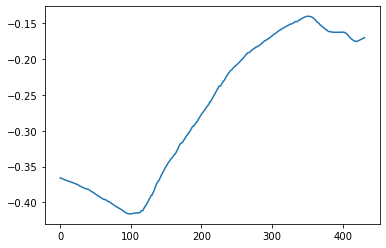

In [159]:
plt.plot(scores)

In [161]:
dic["score"] = scores

In [167]:
score_data = dic.groupby(['date'])["score"].mean()

In [168]:
score_data

date
2020/01/01   -0.171483
2020/01/05   -0.173929
2020/01/06   -0.172744
2020/01/07   -0.163515
2020/01/08   -0.158801
2020/01/09   -0.142317
2020/01/10   -0.151577
2020/01/11   -0.161137
2020/01/12   -0.164466
2020/01/13   -0.170958
2020/01/14   -0.185086
2020/01/15   -0.201978
2020/01/16   -0.215444
2020/01/17   -0.232523
2020/01/18   -0.239736
2020/01/19   -0.246923
2020/01/20   -0.268224
2020/01/21   -0.297601
2020/01/22   -0.318276
2020/01/23   -0.336158
2020/01/24   -0.348888
2020/01/25   -0.354293
2020/01/26   -0.359783
2020/01/27   -0.373391
2020/01/28   -0.408226
2020/01/29   -0.405432
2020/01/30   -0.392706
2020/01/31   -0.375589
Name: score, dtype: float64

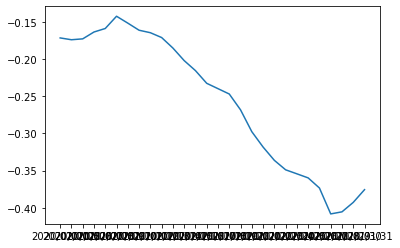

In [166]:
plt.plot(score_data)